In [ ]:
from keras.layers import *
from keras.models import *
from keras import optimizers
from keras import callbacks

##Checking data

First label = 0, Last label = 11, 
Total number of segmentation classes = 12


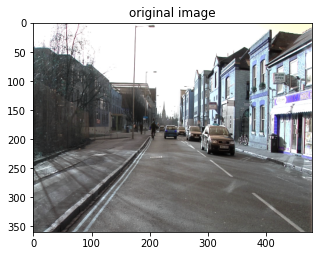

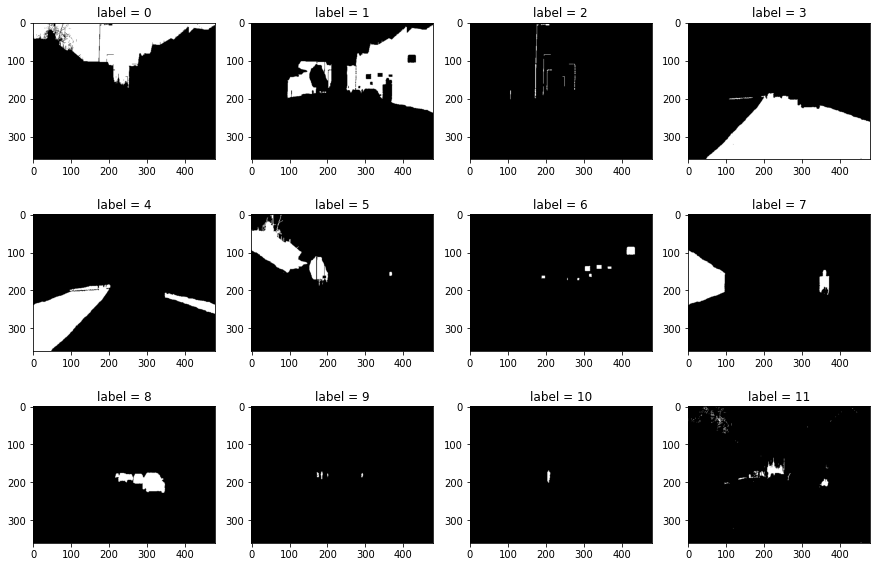

In [ ]:
dir_data = './dataset/'
dir_seg = './dataset/annotations_prepped_train/'
dir_img = './dataset/images_prepped_train/'

import cv2, os
import numpy as np
import matplotlib.pyplot as plt

ldseg = np.array(os.listdir(dir_seg))
fnm = ldseg[0]      #first image file
seg = cv2.imread(dir_seg + fnm) 
img_is = cv2.imread(dir_img + fnm)

min, max = np.min(seg), np.max(seg)
n_classes = max - min + 1
print('First label = {}, Last label = {}, \nTotal number of segmentation classes = {}'.format(min, max, n_classes))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.imshow(img_is)
ax.set_title("original image")
plt.show()

fig = plt.figure(figsize=(15,10))
for k in range(min, max+1):
    ax = fig.add_subplot(3, n_classes/3, k+1)
    ax.imshow((seg == k)*1.0)
    ax.set_title("label = {}".format(k))
plt.show()

##Preprocessing

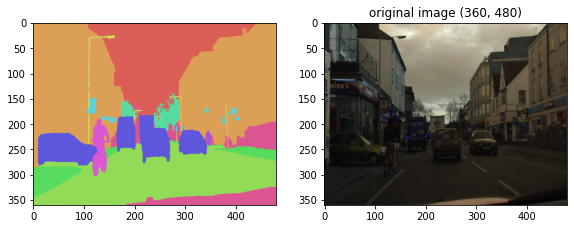

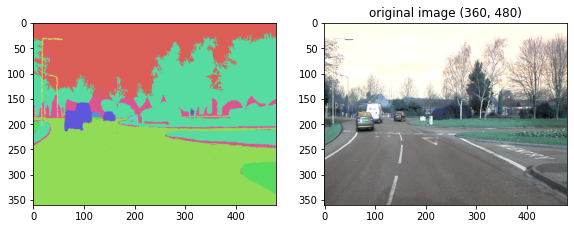

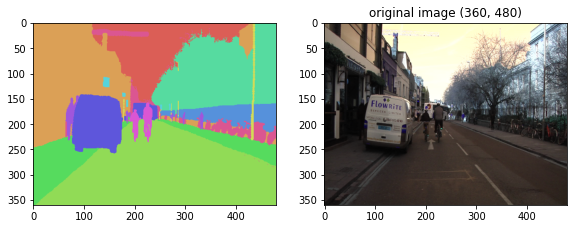

In [ ]:
import random
import seaborn as sns

def give_color_to_seg_img(seg, n_classes):
    if len(seg.shape)==3:
        seg = seg[:,:,0]
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

input_height , input_width = 224 , 224
output_height , output_width = 224 , 224

ldseg = np.array(os.listdir(dir_seg))
for fnm in ldseg[np.random.choice(len(ldseg),3,replace=False)]:
    fnm = fnm.split(".")[0]
    seg = cv2.imread(dir_seg + fnm + ".png") # (360, 480, 3)
    img_is = cv2.imread(dir_img + fnm + ".png")
    seg_img = give_color_to_seg_img(seg,n_classes)

    fig = plt.figure(figsize=(20,40))
    ax = fig.add_subplot(1,4,1)
    ax.imshow(seg_img)
    
    ax = fig.add_subplot(1,4,2)
    ax.imshow(img_is/255.0)
    ax.set_title("original image {}".format(img_is.shape[:2]))

In [ ]:
def getImageArr(path, width, height):
        img = cv2.imread(path, 1)
        img = np.float32(cv2.resize(img, (width, height))) / 127.5 - 1
        return img
def getSegmentationArr(path, nClasses, width, height):
    seg_labels = np.zeros((height, width, nClasses))
    img = cv2.imread(path, 1)
    img = cv2.resize(img, (width , height))
    img = img[:, :, 0]
    for c in range(nClasses):
        seg_labels[:, :, c] = (img == c).astype(int)
    return seg_labels

images = os.listdir(dir_img)
images.sort()
segmentations = os.listdir(dir_seg)
segmentations.sort()

X = []
Y = []
for im , seg in zip(images, segmentations):
    X.append(getImageArr(dir_img + im , input_width , input_height))
    Y.append(getSegmentationArr(dir_seg + seg , n_classes , output_width , output_height))

X, Y = np.array(X), np.array(Y)
print(X.shape, Y.shape)

(367, 224, 224, 3) (367, 224, 224, 12)


##FCN8

In [ ]:
class FCN8:
  def __init__(self):
    self.model = None
 
  def build(self, nclasses, input_dim):
    input = Input(shape = input_dim)
    #block 1
    C1 = Conv2D(64, (3, 3), padding='same', activation='relu', data_format='channels_last', name='block1_conv1')(input)
    C2 = Conv2D(64, (3, 3), padding='same', activation='relu', data_format='channels_last', name='block1_conv2')(C1)
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), data_format='channels_last', name='block1_pool')(C2)
    #block 2
    C3 = Conv2D(128, (3, 3), padding='same', activation='relu', data_format='channels_last', name='block2_conv1')(pool1)
    C4 = Conv2D(128, (3, 3), padding='same', activation='relu', data_format='channels_last', name='block2_conv2')(C3)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), data_format='channels_last', name='block2_pool')(C4)
    #block 3
    C5 = Conv2D(256, (3, 3), padding='same', activation='relu', data_format='channels_last', name='block3_conv1')(pool2)
    C6 = Conv2D(256, (3, 3), padding='same', activation='relu', data_format='channels_last', name='block3_conv2')(C5)
    C7 = Conv2D(256, (3, 3), padding='same', activation='relu', data_format='channels_last', name='block3_conv3')(C6)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), data_format='channels_last', name='block3_pool')(C7)
    #block 4
    C8 = Conv2D(512, (3, 3), padding='same', activation='relu', data_format='channels_last', name='block4_conv1')(pool3)
    C9 = Conv2D(512, (3, 3), padding='same', activation='relu', data_format='channels_last', name='block4_conv2')(C8)
    C10 = Conv2D(512, (3, 3), padding='same', activation='relu', data_format='channels_last', name='block4_conv3')(C9)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), data_format='channels_last', name='block4_pool')(C10) 
    #block 5
    C11 = Conv2D(512, (3, 3), padding='same', activation='relu', data_format='channels_last', name='block5_conv1')(pool4)
    C12 = Conv2D(512, (3, 3), padding='same', activation='relu', data_format='channels_last', name='block5_conv2')(C11)
    C13 = Conv2D(512, (3, 3), padding='same', activation='relu', data_format='channels_last', name='block5_conv3')(C12)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), data_format='channels_last', name='block5_pool')(C13)
    #conv6-7
    conv6 = Conv2D(4096, (7, 7), padding='same', activation='relu', data_format='channels_last', name='conv6')(pool5)
    conv6 = Dropout(rate=0.6)(conv6)
    conv7 = Conv2D(4096, (1, 1), padding='same', activation='relu', data_format='channels_last', name='conv7')(conv6)
    conv7 = Dropout(rate=0.6)(conv7)
    #upsampling & skip connections
    conv7_up4 = Conv2DTranspose(nclasses, kernel_size=(4, 4), strides=(4, 4), padding='same', use_bias=False, data_format='channels_last')(conv7)
    conv_pool4 = Conv2D(nclasses, (1, 1), padding='same', activation='relu', data_format='channels_last', name='conv_pool4')(pool4)
    conv_pool4_up2 = Conv2DTranspose(nclasses, kernel_size=(2, 2), strides=(2, 2), padding='same', use_bias=False, data_format='channels_last')(conv_pool4)
    conv_pool3 = Conv2D(nclasses, (1, 1), padding='same', activation='relu', data_format='channels_last', name='conv_pool3')(pool3)

    Sum = Add(name='add')([conv7_up4, conv_pool4_up2, conv_pool3])
    Sum_up8 = Conv2DTranspose(nclasses, kernel_size=(8, 8), strides=(8, 8), padding='same', use_bias=False, data_format='channels_last')(Sum)
    output = Activation('softmax')(Sum_up8)
    
    self.model = Model(input, output)
    self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  def train(self, x_train, y_train, x_test, y_test):
    earlystopping = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
    return self.model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=200, verbose=1, callbacks=[earlystopping])
  
  def load(self, model_file):
    self.model.load_model(model_file)
  
  def save(self, model_file):
    self.model.save(model_file)
  
  def summary(self):
    self.model.summary()

  def evaluate(self, x_test, y_test):
    return self.model.evaluate(x_test, y_test, batch_size=32)
  
  def predict(self, x_test):
    return self.model.predict(x_test)

In [ ]:
model = FCN8()
model.build(n_classes, (input_width, input_height, 3))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

##Training session

In [ ]:
train_rate = 0.85
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate), replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))

from sklearn.utils import shuffle
X, Y = shuffle(X, Y)
x_train, y_train = X[index_train], Y[index_train]
x_test, y_test = X[index_test], Y[index_test]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(311, 224, 224, 3) (311, 224, 224, 12)
(56, 224, 224, 3) (56, 224, 224, 12)


In [ ]:
hist = model.train(x_train, y_train, x_test, y_test)

Epoch 1/200
10/10 [==============================] - 13s 1s/step - loss: 2.5149 - accuracy: 0.1045 - val_loss: 2.4832 - val_accuracy: 0.1425
Epoch 2/200
10/10 [==============================] - 11s 1s/step - loss: 2.4795 - accuracy: 0.1438 - val_loss: 2.4255 - val_accuracy: 0.1478
Epoch 3/200
10/10 [==============================] - 10s 1s/step - loss: 2.3873 - accuracy: 0.1642 - val_loss: 2.2134 - val_accuracy: 0.2229
Epoch 4/200
10/10 [==============================] - 10s 1s/step - loss: 2.1450 - accuracy: 0.2415 - val_loss: 1.9302 - val_accuracy: 0.2966
Epoch 5/200
10/10 [==============================] - 10s 997ms/step - loss: 1.9254 - accuracy: 0.3038 - val_loss: 1.6841 - val_accuracy: 0.3319
Epoch 6/200
10/10 [==============================] - 10s 1s/step - loss: 1.7472 - accuracy: 0.3224 - val_loss: 1.6125 - val_accuracy: 0.3435
Epoch 7/200
10/10 [==============================] - 10s 998ms/step - loss: 1.5990 - accuracy: 0.3868 - val_loss: 1.3613 - val_accuracy: 0.5158
Epoch 8

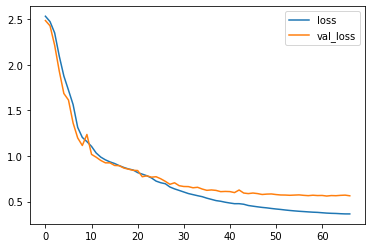

In [ ]:
for key in ['loss', 'val_loss']:
  plt.plot(hist.history[key], label=key)
plt.legend()
plt.show()

In [ ]:
eval = model.evaluate(x_test, y_test)

2/2 [==============================] - 1s 266ms/step - loss: 0.5608 - accuracy: 0.8414


In [ ]:
model.save('./fcn8.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
y_pred = model.predict(x_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_test, axis=3)
print(y_testi.shape,y_predi.shape)

(56, 224, 224) (56, 224, 224)


In [ ]:
def IoU(Yi,y_predi):
    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean IoU: {:4.3f}".format(mIoU))
    
IoU(y_testi,y_predi)

class 00: #TP=464029, #FP= 71511, #FN=15192, IoU=0.843
class 01: #TP=494326, #FP= 90511, #FN=76598, IoU=0.747
class 02: #TP=     7, #FP=    35, #FN=35367, IoU=0.000
class 03: #TP=903670, #FP= 60677, #FN=28704, IoU=0.910
class 04: #TP= 67604, #FP= 30342, #FN=50692, IoU=0.455
class 05: #TP=275185, #FP=115188, #FN=51470, IoU=0.623
class 06: #TP=  1278, #FP=  1977, #FN=38888, IoU=0.030
class 07: #TP= 11947, #FP= 12057, #FN=22070, IoU=0.259
class 08: #TP= 99640, #FP= 34564, #FN=47554, IoU=0.548
class 09: #TP=   525, #FP=  1651, #FN=16910, IoU=0.028
class 10: #TP=   461, #FP=   299, #FN= 9778, IoU=0.044
class 11: #TP= 45554, #FP= 26818, #FN=52407, IoU=0.365
_________________
Mean IoU: 0.404


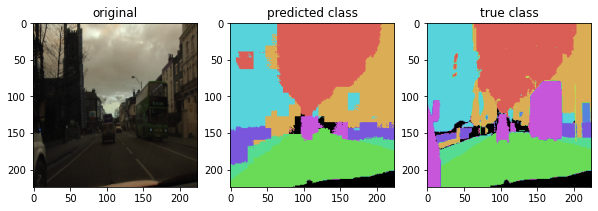

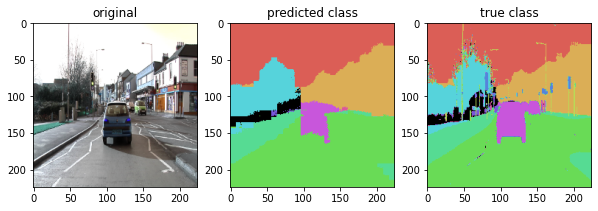

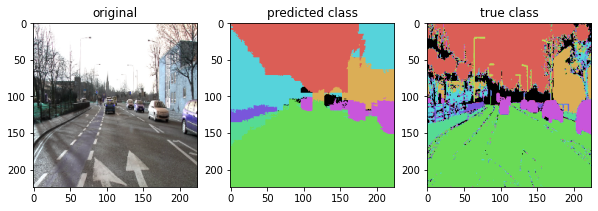

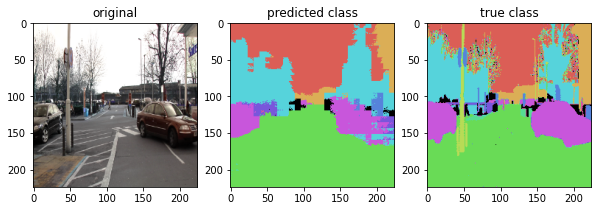

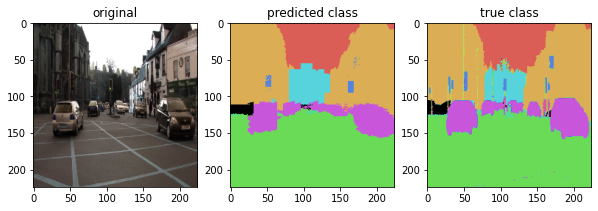

In [ ]:
shape = (224,224)
n_classes= 10

for i in range(5,10):
    img_is  = (x_test[i] + 1)*(255.0/2)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(10,30))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_is/255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(give_color_to_seg_img(seg,n_classes))
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(give_color_to_seg_img(segtest,n_classes))
    ax.set_title("true class")
    plt.show()